In [10]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as mse
from statsmodels.tools.eval_measures import rmse

# <span style="color: green;">READING IN DATA</span>

In [2]:
# Reading in dataset
# Specify filenames of datasets
all_income = 'final_cleaned_dummy_data.csv'
low_income = 'lowIncomeFilteredData.csv'

# Specify columns to drop
response_var = ['BURDEN']
calc_response_list =  ['HINCP', 'ELECAMT', 'GASAMT', 'OILAMT', 'OTHERAMT']
other_list = ['METRO', 'DIVISION', 'Unnamed:', 'index', 'YRBUILT']

# Function to read files to dataframe
def read_to_df(filename, response, calc_response, other):
    data = pd.read_csv(filename)
    y = data[response]
    
    # Dropping infinite and nan values of y and corresponding index of data
    j = 0
    for i in y['BURDEN']:
        if i == float('inf'):
            y = y.drop([j])
            data = data.drop([j])
        elif np.isnan(i) == True:
            y = y.drop([j])
            data = data.drop([j])
        j += 1
    
    # Agnostic drop code (can drop any column as long as it contains specific word)
    for i in data:
        if '_' in i:
            if i.split('_')[0] in calc_response_list+response_var+other_list:
                data = data.drop(i, axis=1)
        elif ' ' in i:
            if i.split(' ')[0] in calc_response_list+response_var+other_list:
                data = data.drop(i, axis=1)
        elif i in calc_response_list+response_var+other_list:
            data = data.drop(i, axis=1)

    return y, data

# <span style="color: red;">SIMPLE LINEAR REGRESSION</span>

In [3]:
# Creating the model
y_all, all_income_df = read_to_df(all_income, response_var, calc_response_list, other_list)
y_low, low_income_df = read_to_df(low_income, response_var, calc_response_list, other_list)
y_all, y_low = y_all['BURDEN'], y_low['BURDEN']

In [4]:
# Simple linear regression with best predictor
def SLR(data, response):
    
    # Find best predictor
    compare = 0
    for i in data.columns:
        data_basis = data[i]
        data_basis = np.array(data_basis).reshape(-1, 1)
        regr = linear_model.LinearRegression()
        regr.fit(data_basis, response)
        y_pred = regr.predict(data_basis)
        if r2_score(response, y_pred) > compare:
            y_pred_best = y_pred
            compare = r2_score(response, y_pred)
            predictor_best = i
    
    MSE = mse(response, y_pred_best)

    return y_pred_best, predictor_best, compare, MSE

# <span style="color: blue;">Unskewed response variable</span>

In [5]:
def response_unskew(data, y):
    p = np.percentile(y, 95)
    index = y.index
    j = 0
    for i in y:
        if i > p:
            y = y.drop([index[j]])
            data = data.drop([index[j]])
        elif i <= 0:
            y = y.drop([index[j]])
            data = data.drop([index[j]])
        j += 1
    return data, y

In [6]:
# SLR and unskew data creation
all_income_df, y_all = response_unskew(all_income_df, y_all)
low_income_df, y_low = response_unskew(low_income_df, y_low)   
y_pred_all, predictor_best_all, compare_all, MSE_all = SLR(all_income_df, y_all)
y_pred_low, predictor_best_low, compare_low, MSE_low = SLR(low_income_df, y_low)

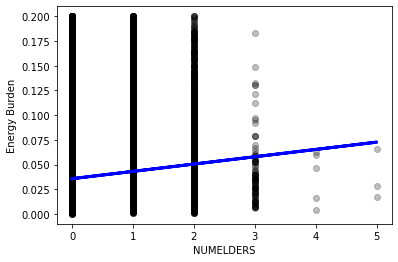

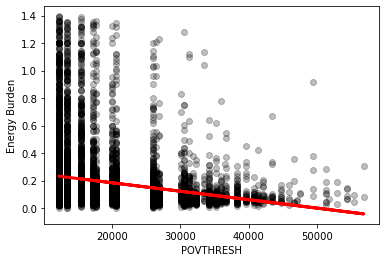

In [7]:
# Plot All Income
plt.scatter(all_income_df[predictor_best_all], y_all, color='black', alpha = 0.25)
plt.plot(all_income_df[predictor_best_all], y_pred_all, color='blue', linewidth=3)
plt.xlabel(predictor_best_all)
plt.ylabel('Energy Burden')

plt.show()

# Plot Low Income
plt.scatter(low_income_df[predictor_best_low], y_low, color='black', alpha = 0.25)
plt.plot(low_income_df[predictor_best_low], y_pred_low, color='red', linewidth=3)
plt.xlabel(predictor_best_low)
plt.ylabel('Energy Burden')

plt.show()

In [8]:
# Best R2
print('Best R2 of SLR on all income: ',compare_all)
print('Best R2 of SLR on low income: ', compare_low)
print('MSE on all income: ', MSE_all)
print('MSE on low income: ', MSE_low)

Best R2 of SLR on all income:  0.02268635453112522
Best R2 of SLR on low income:  0.03890449356933112
MSE on all income:  0.001136188184539005
MSE on low income:  0.05463023810551021


# <span style="color: blue;">MULTIPLE LINEAR REGRESSION</span>

In [12]:
# Intercept
all_income_dfI = all_income_df.assign(Intercept=1)
low_income_dfI = low_income_df.assign(Intercept=1)

def MLR(data, response):
    # Creating the model
    sm_model = sm.OLS(response, data)

    # Multiple Linear Regression
    results = sm_model.fit()
    ypred = results.predict(data)

    # Summary
    data_summary = results.summary()
    MSE = rmse(response, ypred)
    return data_summary, MSE

all_summary, all_rmse = MLR(all_income_dfI, y_all)
low_summary, low_rmse = MLR(low_income_dfI, y_low)
display(all_summary)
display(low_summary)

print('MSE for all income: ', all_rmse)
print('MSE for low income: ', low_rmse)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     111.0
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:12:30   Log-Likelihood:                 85292.
No. Observations:               41921   AIC:                        -1.705e+05
Df Residuals:                   41859   BIC:                        -1.699e+05
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
ACPRIMARY_0    -0.0031      0.001     -4.475      0.000      -0.004      -0.002
ACPRIMARY_1     0.0025      0.001      4.144      0.000       0.001       0.004
ACPRIMARY_2     0.0031      0.001      2.708      0.007       0.001       0.005
ACPRIMARY_3     0.0047      0.003      1.442      0.149      -0.002       0.011
ACPRIMARY_4     0.0049      0.001      6.302      0.000       0.003       0.006
ACPRIMARY_5     0.0059      0.001      7.149      0.000       0.004       0.008
ACPRIMARY_6     0.0046      0.001      4.548      0.000       0.003       0.007
ACPRIMARY_7     0.0066      0.001      5.133      0.000       0.004       0.009
BLD_1           0.0216      0.001     28.624      0.000       0.020       0.023
BLD_2           0.0111      0.000     25.960      0.000       0.010       0.012
BLD_3           0.0070      0.001     10.922      0.000       0.006       0.008
BLD_4           0.0050      0.001      5.437      0.000       0.003       0.007
BLD_5           0.0024      0.001      3.143      0.002       0.001       0.004
BLD_6          -0.0012      0.001     -1.703      0.089      -0.003       0.000
BLD_7          -0.0053      0.001     -7.159      0.000      -0.007      -0.004
BLD_8          -0.0049      0.001     -6.035      0.000      -0.006      -0.003
BLD_9          -0.0065      0.001     -8.637      0.000      -0.008      -0.005
COOKFUEL_0      0.0059      0.004      1.622      0.105      -0.001       0.013
COOKFUEL_1      0.0056      0.002      3.296      0.001       0.002       0.009
COOKFUEL_2      0.0064      0.002      3.696      0.000       0.003       0.010
COOKFUEL_3      0.0078      0.002      4.199      0.000       0.004       0.011
COOKFUEL_4      0.0035      0.007      0.535      0.592      -0.009       0.016
HEATFUEL_0      0.0038      0.001      2.600      0.009       0.001       0.007
HEATFUEL_1      0.0018      0.001      1.253      0.210      -0.001       0.005
HEATFUEL_2     -0.0005      0.001     -0.318      0.750      -0.003       0.002
HEATFUEL_3      0.0157      0.002      9.173      0.000       0.012       0.019
HEATFUEL_4      0.0103      0.002      5.843      0.000       0.007       0.014
HEATFUEL_5      0.0070      0.004      1.978      0.048    6.51e-05       0.014
HEATFUEL_6      0.0044      0.007      0.598      0.550      -0.010       0.019
HEATFUEL_7      0.0001      0.002      0.060      0.952      -0.004       0.004
HEATFUEL_8     -0.0031      0.008     -0.389      0.697      -0.019       0.013
HEATFUEL_9     -0.0104      0.004     -2.599      0.009      -0.018      -0.003
HEATTYPE_0      0.0038      0.001      2.600      0.009       0.001       0.007
HEATTYPE_1      0.0004      0.001      0.402      0.688      -0.001       0.002
HEATTYPE_2      0.0037      0.001      3.335      0.001       0.002       0.006
HEATTYPE_3     -0.0019      0.001     -1.80

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     28.74
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           6.18e-95
Time:                        21:12:30   Log-Likelihood:                 364.20
No. Observations:                7653   AIC:                            -690.4
Df Residuals:                    7634   BIC:                            -558.5
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ACPRIMARY     -0.0017      0.002     -1.025      0.306      -0.005       0.002
BLD           -0.0029      0.001     -2.046      0.041      -0.006      -0.000
COOKFUEL       0.0097      0.005      1.790      0.073      -0.001       0.020
FIREPLACE      0.0065      0.007      0.905      0.366      -0.008       0.020
HEATFUEL      -0.0014      0.003     -0.460      0.646      -0.007       0.005
HEATTYPE       0.0003      0.001      0.255      0.799      -0.002       0.003
HHRACE         0.0028      0.003      0.984      0.325      -0.003       0.008
HOTWATER       0.0125      0.005      2.421      0.016       0.002       0.023
NUMELDERS      0.0132      0.006      2.044      0.041       0.001       0.026
NUMYNGKIDS     0.0125      0.004      3.212      0.001       0.005       0.020
NUMOLDKIDS     0.0050      0.003      1.630      0.103      -0.001       0.011
URBAN          0.0352      0.008      4.357      0.000       0.019       0.051
SOLAR          0.0007      0.019      0.039      0.969      -0.036       0.038
TENURE        -0.0135      0.006     -2.118      0.034      -0.026      -0.001
UNITSIZE       0.0052      0.002      2.631      0.009       0.001       0.009
NUMPEOPLE     -0.0307      0.016     -1.927      0.054      -0.062       0.001
HHAGE          0.0011      0.000      4.528      0.000       0.001       0.002
NUMKIDS        0.0175      0.003      5.797      0.000       0.012       0.023
POVTHRESH  -5.246e-07   1.03e-06     -0.507      0.612   -2.55e-06     1.5e-06
LITHRESH   -7.868e-07   1.55e-06     -0.507      0.612   -3.83e-06    2.25e-06
Intercept      0.1605      0.035      4.574      0.000       0.092       0.229
==============================================================================
Omnibus:                     4238.747   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27748.042
Skew:                           2.686   Prob(JB):                         0.00
Kurtosis:                      10.626   Cond. No.                     1.61e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.05e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

MSE for all income:  0.03163409406707774
MSE for low income:  0.23072515193382578


# <span style="color: orange;">MULTICOLLINEARITY VIF TEST</span>

In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each predictive variable, calculate VIF and save in a dataframe called "VIF"
def VIF(data):
    VIF = pd.DataFrame()
    VIF['VIF'] = [variance_inflation_factor(data.values, i) for i in range(data.shape[1])]
    VIF['Predictive Variable'] = data.columns
    VIF = VIF[VIF['Predictive Variable'] != 'Intercept']
    return VIF

VIF_all = VIF(all_income_dfI)
VIF_low = VIF(low_income_dfI)

D:\Anaconda\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
D:\Anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


# <span style="color: blue;">Re-test MLR with dropped Collinear Predictors</span>

In [14]:
def collinear_drop(VIF, data):
    j = 0
    for i in VIF['VIF']:
        if i >= 10:
            data = data.drop([VIF['Predictive Variable'][j]], axis=1)
        j += 1
    return data

# Drop collinear predictors
all_income_dfI_ncl = collinear_drop(VIF_all, all_income_dfI)
low_income_dfI_ncl = collinear_drop(VIF_low, low_income_dfI)

In [15]:
all_summary_ncl, all_rmse_ncl = MLR(all_income_dfI_ncl, y_all)
low_summary_ncl, low_rmse_ncl = MLR(low_income_dfI_ncl, y_low)

display(all_summary_ncl)
display(low_summary_ncl)
print('MSE for all income: ', all_rmse_ncl)
print('MSE for low income: ', low_rmse_ncl)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.086
Method:                 Least Squares   F-statistic:                     492.6
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        21:14:11   Log-Likelihood:                 84033.
No. Observations:               41921   AIC:                        -1.680e+05
Df Residuals:                   41912   BIC:                        -1.680e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
FIREPLACE     -0.0064      0.000    -17.618      0.000      -0.007      -0.006
NUMELDERS      0.0094      0.000     39.014      0.000       0.009       0.010
NUMYNGKIDS     0.0076      0.000     19.060      0.000       0.007       0.008
NUMOLDKIDS     0.0091      0.000     31.560      0.000       0.009       0.010
URBAN         -0.0124      0.001    -22.208      0.000      -0.014      -0.011
SOLAR         -0.0033      0.001     -3.692      0.000      -0.005      -0.002
UNITSIZE      -0.0014      0.000    -13.447      0.000      -0.002      -0.001
NUMPEOPLE     -0.0053      0.000    -29.181      0.000      -0.006      -0.005
Intercept      0.0644      0.001     87.690      0.000       0.063       0.066
==============================================================================
Omnibus:                    15488.528   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            55820.031
Skew:                           1.875   Prob(JB):                         0.00
Kurtosis:                       7.230   Cond. No.                         34.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     21.61
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           5.25e-55
Time:                        21:14:12   Log-Likelihood:                 261.92
No. Observations:                7653   AIC:                            -493.8
Df Residuals:                    7638   BIC:                            -389.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
ACPRIMARY     -0.0028      0.002     -1.673      0.094      -0.006       0.000
BLD            0.0006      0.001      0.459      0.646      -0.002       0.003
COOKFUEL       0.0046      0.005      0.833      0.405      -0.006       0.015
FIREPLACE      0.0065      0.007      0.893      0.372      -0.008       0.021
HEATFUEL       0.0007      0.003      0.214      0.831      -0.005       0.007
HEATTYPE    7.234e-06      0.001      0.005      0.996      -0.003       0.003
HHRACE         0.0009      0.003      0.297      0.766      -0.005       0.007
HOTWATER       0.0113      0.005      2.165      0.030       0.001       0.022
NUMELDERS      0.0028      0.006      0.484      0.628      -0.009       0.014
URBAN          0.0278      0.008      3.398      0.001       0.012       0.044
SOLAR         -0.0055      0.019     -0.287      0.774      -0.043       0.032
TENURE        -0.0195      0.006     -3.041      0.002      -0.032      -0.007
UNITSIZE       0.0003      0.002      0.177      0.860      -0.003       0.004
HHAGE          0.0021      0.000      9.595      0.000       0.002       0.003
Intercept      0.0517      0.022      2.352      0.019       0.009       0.095
==============================================================================
Omnibus:                     4281.000   Durbin-Watson:                   1.935
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28249.448
Skew:                           2.718   Prob(JB):                         0.00
Kurtosis:                      10.684   Cond. No.                         496.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MSE for all income:  0.03259817581589851
MSE for low income:  0.23382942934036288


# <span style="color: blue;">Re-test MLR low with only significant categorical predictors (alpha = 0.05)</span>

In [16]:
Sig_Pred_low = ['HOTWATER', 'URBAN', 'TENURE', 'Intercept']
for i in low_income_dfI_ncl:
    if i not in Sig_Pred_low:
        low_income_dfI_ncl = low_income_dfI_ncl.drop([i], axis=1)

low_summary_ncl_sig, low_MSE_sig = MLR(low_income_dfI_ncl, y_low)
display(low_summary_ncl_sig)
print('MSE for low income: ', low_MSE_sig)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BURDEN   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     33.99
Date:                Thu, 09 Dec 2021   Prob (F-statistic):           8.18e-22
Time:                        21:18:24   Log-Likelihood:                 163.97
No. Observations:                7653   AIC:                            -319.9
Df Residuals:                    7649   BIC:                            -292.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
HOTWATER       0.0144      0.004      3.239      0.001       0.006       0.023
URBAN          0.0310      0.008      3.852      0.000       0.015       0.047
TENURE        -0.0427      0.005     -8.489      0.000      -0.053      -0.033
Intercept      0.2057      0.012     16.706      0.000       0.182       0.230
==============================================================================
Omnibus:                     4381.255   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29807.634
Skew:                           2.787   Prob(JB):                         0.00
Kurtosis:                      10.899   Cond. No.                         12.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

MSE for low income:  0.23684149635280893
